# Telecom Churn Case Study

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold,cross_val_score,GridSearchCV,RandomizedSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler


from sklearn.decomposition import PCA , IncrementalPCA
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import make_classification
from scipy import stats
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')


## Reading and Understanding Data

In [117]:
# Read the training dataset
train_db = pd.read_csv("train.csv")
train_db.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [118]:
# lets check the dimensions of the dataset
train_db.shape

(69999, 172)

In [119]:
# Check Info 
train_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [120]:
# Check description
train_db.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,109.0,0.0,0.0,0.0,283.134365,278.185912,278.858826,133.153275,133.894438,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,334.213918,344.366927,351.924315,299.963093,311.277193,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,109.0,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,93.581000,86.714000,84.095000,7.410000,6.675000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,197.484000,191.588000,192.234000,34.110000,32.280000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,370.791000,365.369500,369.909000,119.390000,115.837500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


## Data Cleaning

In [8]:
# Identify the date columns
date_cols = [k for k in train_db.columns.to_list() if 'date' in k]
date_cols

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [121]:
#Drop Date Columns
train_db=train_db.drop(date_cols,axis=1)

In [122]:
# Identify the Recharge columns
recharge_cols = [k for k in train_db.columns.to_list() if 'rech' in k]
recharge_cols

['total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8']

In [123]:
# Impute Recharge columns with 0
for col in recharge_cols:
    train_db[col]=train_db[col].fillna(0)

In [124]:
# Cheking percent of missing values in columns
df_missing_columns = (100*(train_db.isnull().sum()/len(train_db.index)).to_frame('null')).sort_values('null',ascending=False)
df_missing_columns

,null
night_pck_user_6,74.902499
arpu_3g_6,74.902499
arpu_2g_6,74.902499
fb_user_6,74.902499
fb_user_7,74.478207
...,...
total_rech_data_6,0.000000
last_day_rch_amt_8,0.000000
last_day_rch_amt_7,0.000000
last_day_rch_amt_6,0.000000


In [125]:
# List the columns having more than 50% missing values
col_list_missing_50 = list(df_missing_columns.index[df_missing_columns['null'] > 50])
col_list_missing_50

['night_pck_user_6',
 'arpu_3g_6',
 'arpu_2g_6',
 'fb_user_6',
 'fb_user_7',
 'arpu_3g_7',
 'arpu_2g_7',
 'night_pck_user_7',
 'arpu_3g_8',
 'arpu_2g_8',
 'fb_user_8',
 'night_pck_user_8']

In [126]:
# Drop the columns having more than 50% missing values
train_db = train_db.drop(col_list_missing_50, axis=1)

In [127]:
#Check shape
train_db.shape

(69999, 151)

In [128]:
# Cheking again missing values in columns
df_missing_columns = train_db.isnull().sum().to_frame('null').sort_values('null',ascending=False)
df_missing_columns

,null
isd_og_mou_8,3703
std_og_t2c_mou_8,3703
std_ic_t2t_mou_8,3703
loc_og_t2t_mou_8,3703
loc_og_t2m_mou_8,3703
...,...
total_rech_data_7,0
total_rech_data_8,0
max_rech_data_6,0
max_rech_data_7,0


In [129]:
# drop columns with more than 3000 missing values
col_list_3000 = list(df_missing_columns.index[df_missing_columns['null'] >=3000])
col_list_3000

['isd_og_mou_8',
 'std_og_t2c_mou_8',
 'std_ic_t2t_mou_8',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_8',
 'std_og_mou_8',
 'std_ic_t2o_mou_8',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_8',
 'std_ic_mou_8',
 'std_ic_t2m_mou_8',
 'loc_ic_t2m_mou_8',
 'loc_og_mou_8',
 'std_ic_t2f_mou_8',
 'std_og_t2t_mou_8',
 'std_og_t2f_mou_8',
 'roam_og_mou_8',
 'std_og_t2m_mou_8',
 'isd_ic_mou_8',
 'spl_og_mou_8',
 'ic_others_8',
 'loc_ic_t2t_mou_8',
 'offnet_mou_8',
 'loc_ic_mou_8',
 'og_others_8',
 'onnet_mou_8',
 'roam_ic_mou_8',
 'spl_ic_mou_8',
 'loc_ic_t2f_mou_8']

In [130]:
# Drop the columns having more 3000+ missing values
train_db = train_db.drop(col_list_3000, axis=1)

In [131]:
# Check the shape
train_db.shape

(69999, 122)

In [132]:
# Checking columns with unique values
unique_value_cols=train_db.nunique(dropna=True).to_frame('Unique_Values').sort_values('Unique_Values',ascending=True)
unique_value_cols

,Unique_Values
std_ic_t2o_mou_7,1
circle_id,1
loc_og_t2o_mou,1
std_og_t2o_mou,1
loc_ic_t2o_mou,1
...,...
total_og_mou_7,33195
arpu_8,60194
arpu_7,61425
arpu_6,61615


In [133]:
# drop columns with unique values
unique_cols = list(unique_value_cols.index[unique_value_cols['Unique_Values'] ==1])
train_db = train_db.drop(unique_cols, axis=1)

In [134]:
# Checking shape
train_db.shape

(69999, 114)

In [135]:
# Cheking again missing values in columns
df_missing_columns = train_db.isnull().sum().to_frame('null').sort_values('null',ascending=False)
df_missing_columns

,null
og_others_6,2768
loc_og_t2f_mou_6,2768
loc_ic_t2m_mou_6,2768
loc_ic_t2f_mou_6,2768
spl_og_mou_6,2768
...,...
total_rech_data_8,0
max_rech_data_6,0
max_rech_data_7,0
max_rech_data_8,0


In [136]:
# Since there are more number of null values we are dropping cols greater than 2678
col_list_2678 = list(df_missing_columns.index[df_missing_columns['null'] >=2678])
train_db = train_db.drop(col_list_2678, axis=1)

In [137]:
#Check shape
train_db.shape

(69999, 60)

In [138]:
# Cheking again missing values in columns
df_missing_columns = train_db.isnull().sum().to_frame('null').sort_values('null',ascending=False)
df_missing_columns

,null
id,0
arpu_6,0
count_rech_3g_7,0
count_rech_3g_8,0
av_rech_amt_data_6,0
av_rech_amt_data_7,0
av_rech_amt_data_8,0
vol_2g_mb_6,0
vol_2g_mb_7,0
vol_2g_mb_8,0


In [139]:
# Checking again columns with unique values
unique_value_cols=train_db.nunique(dropna=True).to_frame('Unique_Values').sort_values('Unique_Values',ascending=True)
unique_value_cols

,Unique_Values
churn_probability,2
monthly_2g_6,5
monthly_2g_8,6
monthly_2g_7,6
monthly_3g_6,10
monthly_3g_8,12
monthly_3g_7,13
sachet_3g_6,23
count_rech_3g_6,23
sachet_3g_7,26


In [140]:
# drop columns with unique values
unique_cols = list(unique_value_cols.index[unique_value_cols['Unique_Values'] ==1])
train_db = train_db.drop(unique_cols, axis=1)

In [141]:
# Drop Id column which is not useful for analysis
train_db = train_db.drop('id', axis=1)

In [142]:

#Check info again
train_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 59 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   arpu_6              69999 non-null  float64
 1   arpu_7              69999 non-null  float64
 2   arpu_8              69999 non-null  float64
 3   total_og_mou_6      69999 non-null  float64
 4   total_og_mou_7      69999 non-null  float64
 5   total_og_mou_8      69999 non-null  float64
 6   total_ic_mou_6      69999 non-null  float64
 7   total_ic_mou_7      69999 non-null  float64
 8   total_ic_mou_8      69999 non-null  float64
 9   total_rech_num_6    69999 non-null  int64  
 10  total_rech_num_7    69999 non-null  int64  
 11  total_rech_num_8    69999 non-null  int64  
 12  total_rech_amt_6    69999 non-null  int64  
 13  total_rech_amt_7    69999 non-null  int64  
 14  total_rech_amt_8    69999 non-null  int64  
 15  max_rech_amt_6      69999 non-null  int64  
 16  max_

In [143]:
#Check the shape
train_db.shape

(69999, 59)

In [144]:
# Checking columns with unique values
unique_value_cols=train_db.nunique(dropna=True).to_frame('Unique_Values').sort_values('Unique_Values',ascending=True)
unique_value_cols

,Unique_Values
churn_probability,2
monthly_2g_6,5
monthly_2g_8,6
monthly_2g_7,6
monthly_3g_6,10
monthly_3g_8,12
monthly_3g_7,13
sachet_3g_6,23
count_rech_3g_6,23
sachet_3g_7,26


In [145]:
#Remove outliers
z = np.abs(stats.zscore(train_db))
selected = train_db[(z < 3).all(axis=1)]
train_db = train_db.loc[selected.index]

In [146]:
# Checking columns with unique values
unique_value_cols=train_db.nunique(dropna=True).to_frame('Unique_Values').sort_values('Unique_Values',ascending=True)
unique_value_cols.head()

,Unique_Values
monthly_2g_8,1
monthly_2g_7,1
monthly_2g_6,1
churn_probability,2
sachet_3g_7,2


In [147]:
# drop columns with unique values
unique_cols = list(unique_value_cols.index[unique_value_cols['Unique_Values'] ==1])
train_db = train_db.drop(unique_cols, axis=1)

In [148]:
#Check shape
train_db.shape

(47972, 56)

## EDA
## Univariate analysis

<AxesSubplot:xlabel='churn_probability', ylabel='count'>

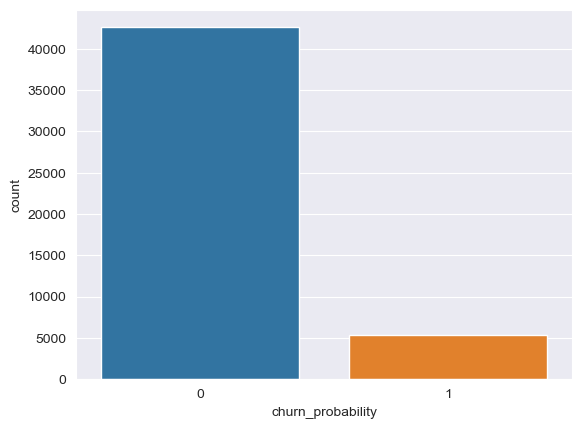

In [149]:
# Plot countplot for churn 
sns.countplot(x="churn_probability",data = train_db)

Observation:
Churn rate is low in overall data but need there is a class imbalance

<AxesSubplot:xlabel='aon', ylabel='Density'>

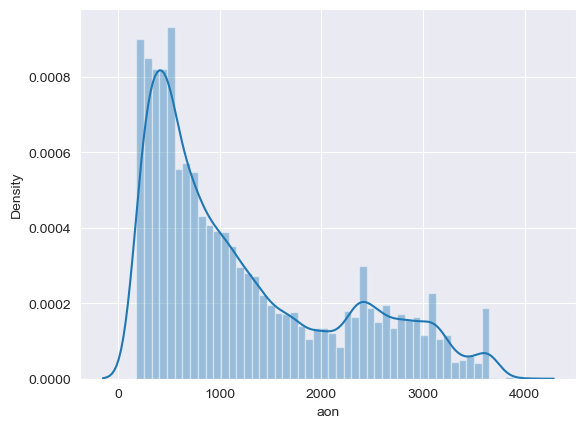

In [150]:
# Plot distplot for aon
sns.distplot(train_db['aon'])

Observation:
The age of the network is Initially high but gradually decreases over the time

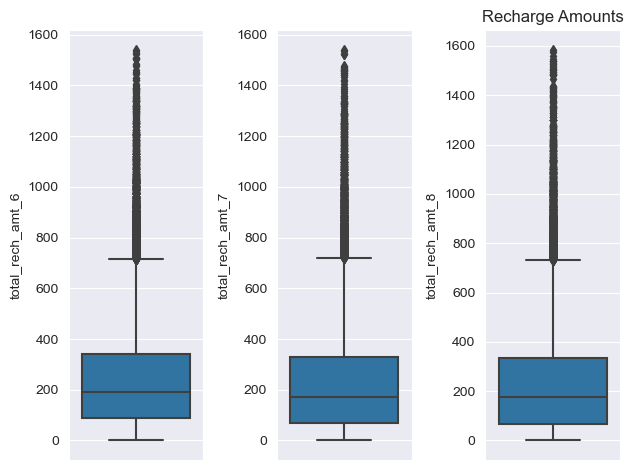

In [165]:
# Box plot for recharge amounts for 6,7,8 months
fig, axes = plt.subplots(1,3)

cols=['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8']
for name, ax in zip(cols, axes.flatten()):
    sns.boxplot(y=name , data=train_db, orient='h', ax=ax)
plt.title('Recharge Amounts')    
plt.tight_layout()

Observation:
The median of recharge amounts is at 200

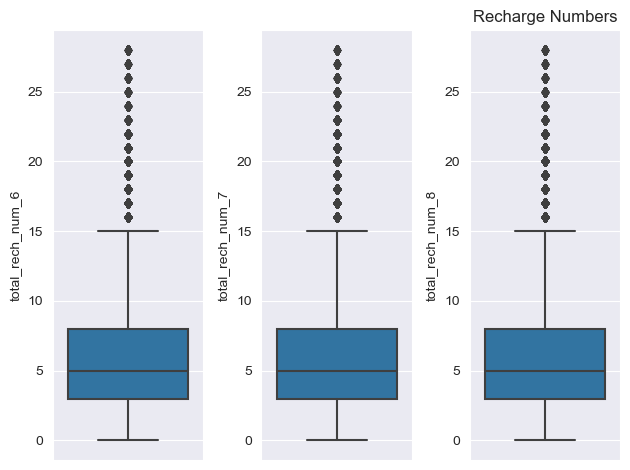

In [152]:
# Box plot for recharge Numbers for 6,7,8 months
fig, axes = plt.subplots(1,3)

cols=['total_rech_num_6','total_rech_num_7','total_rech_num_8']
for name, ax in zip(cols, axes.flatten()):
    sns.boxplot(y=name , data=train_db, orient='h', ax=ax)
plt.title('Recharge Numbers')    
plt.tight_layout()

Observation:
The median of recharge numbers for 6,7,8 months is 5

## Bivariate Analysis

Text(0.5, 0.98, 'Incoming Calls Usage')

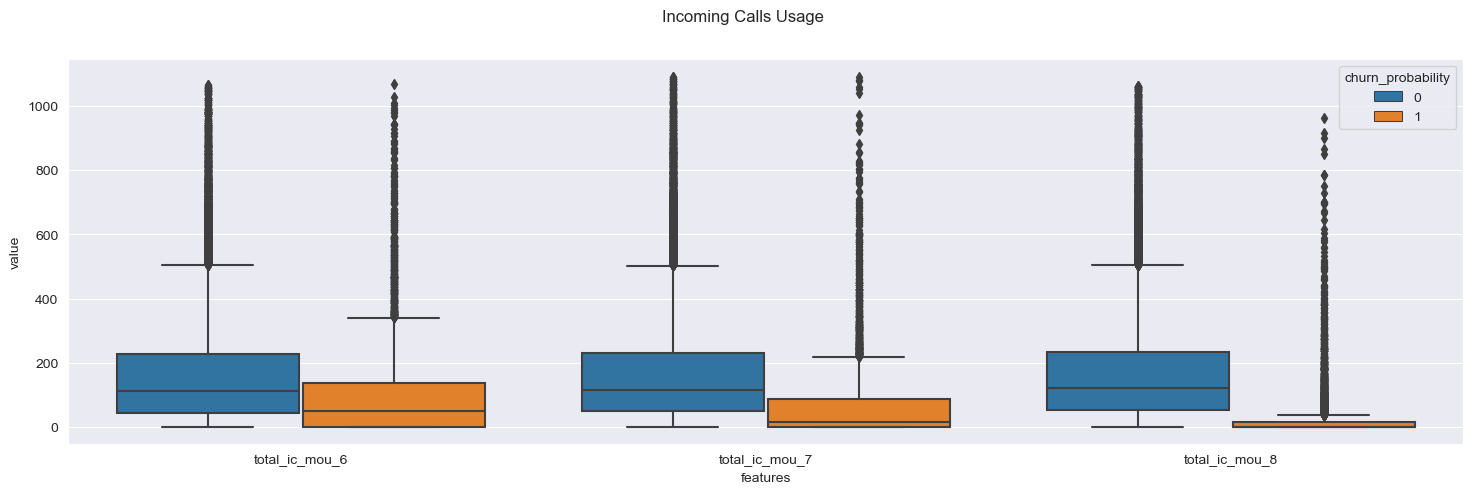

In [153]:
# Plot boxplot for incoming calls vs churn 
df_ic=train_db[["total_ic_mou_6","total_ic_mou_7","total_ic_mou_8","churn_probability"]]
plt.figure(figsize=(18, 5))
X = pd.melt(df_ic,id_vars="churn_probability",var_name="features",value_name='value')
sns.boxplot(x="features", y="value", hue="churn_probability",data = X)  
plt.suptitle('Incoming Calls Usage')

Observation:
The churn probability based on incoming calls for the 6th month is high and is lowest for 8th month

Text(0.5, 0.98, 'Recharge Counts')

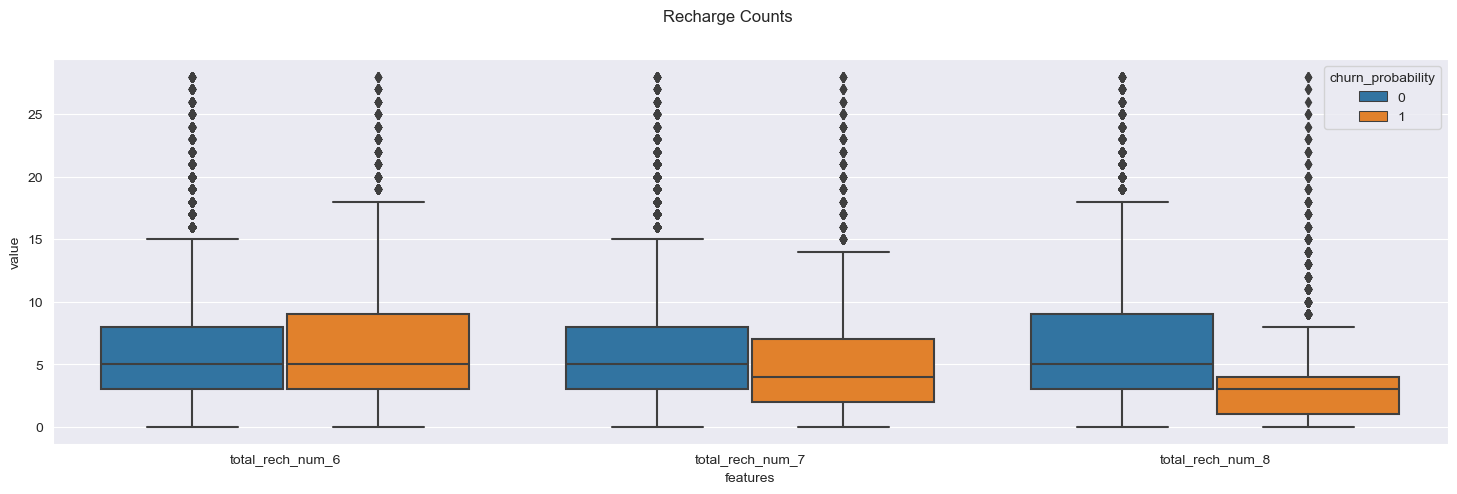

In [154]:
# Plot box plot between Recharge counts and Churn
df_ic=train_db[["total_rech_num_6","total_rech_num_7","total_rech_num_8","churn_probability"]]
plt.figure(figsize=(18, 5))
X = pd.melt(df_ic,id_vars="churn_probability",var_name="features",value_name='value')
sns.boxplot(x="features", y="value", hue="churn_probability",data = X)  
plt.suptitle('Recharge Counts')

Observation:
The churn probability based on Number of Recharges for the 6th month is high and is lowest for 8th month

Text(0.5, 0.98, 'Recharge Counts')

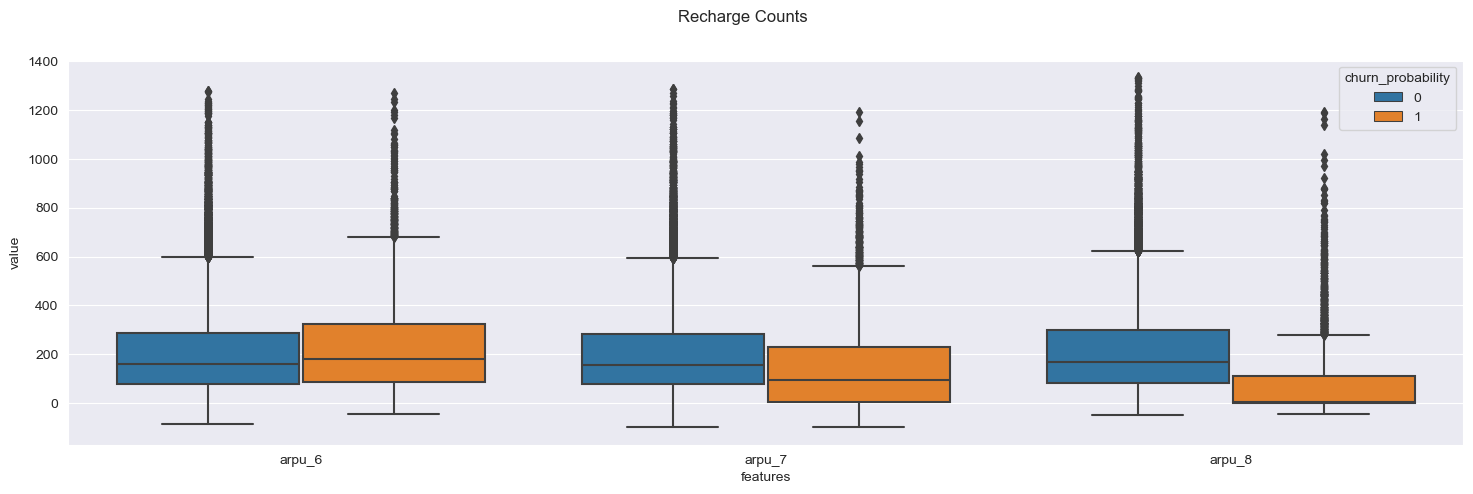

In [155]:
# Plot boxplot between arpu and churn 
df_ic=train_db[["arpu_6","arpu_7","arpu_8","churn_probability"]]
plt.figure(figsize=(18, 5))
X = pd.melt(df_ic,id_vars="churn_probability",var_name="features",value_name='value')
sns.boxplot(x="features", y="value", hue="churn_probability",data = X)  
plt.suptitle('Recharge Counts')

Observation:
The churn probability based on average revenue per user for the 6th month is high and is lowest for 8th month

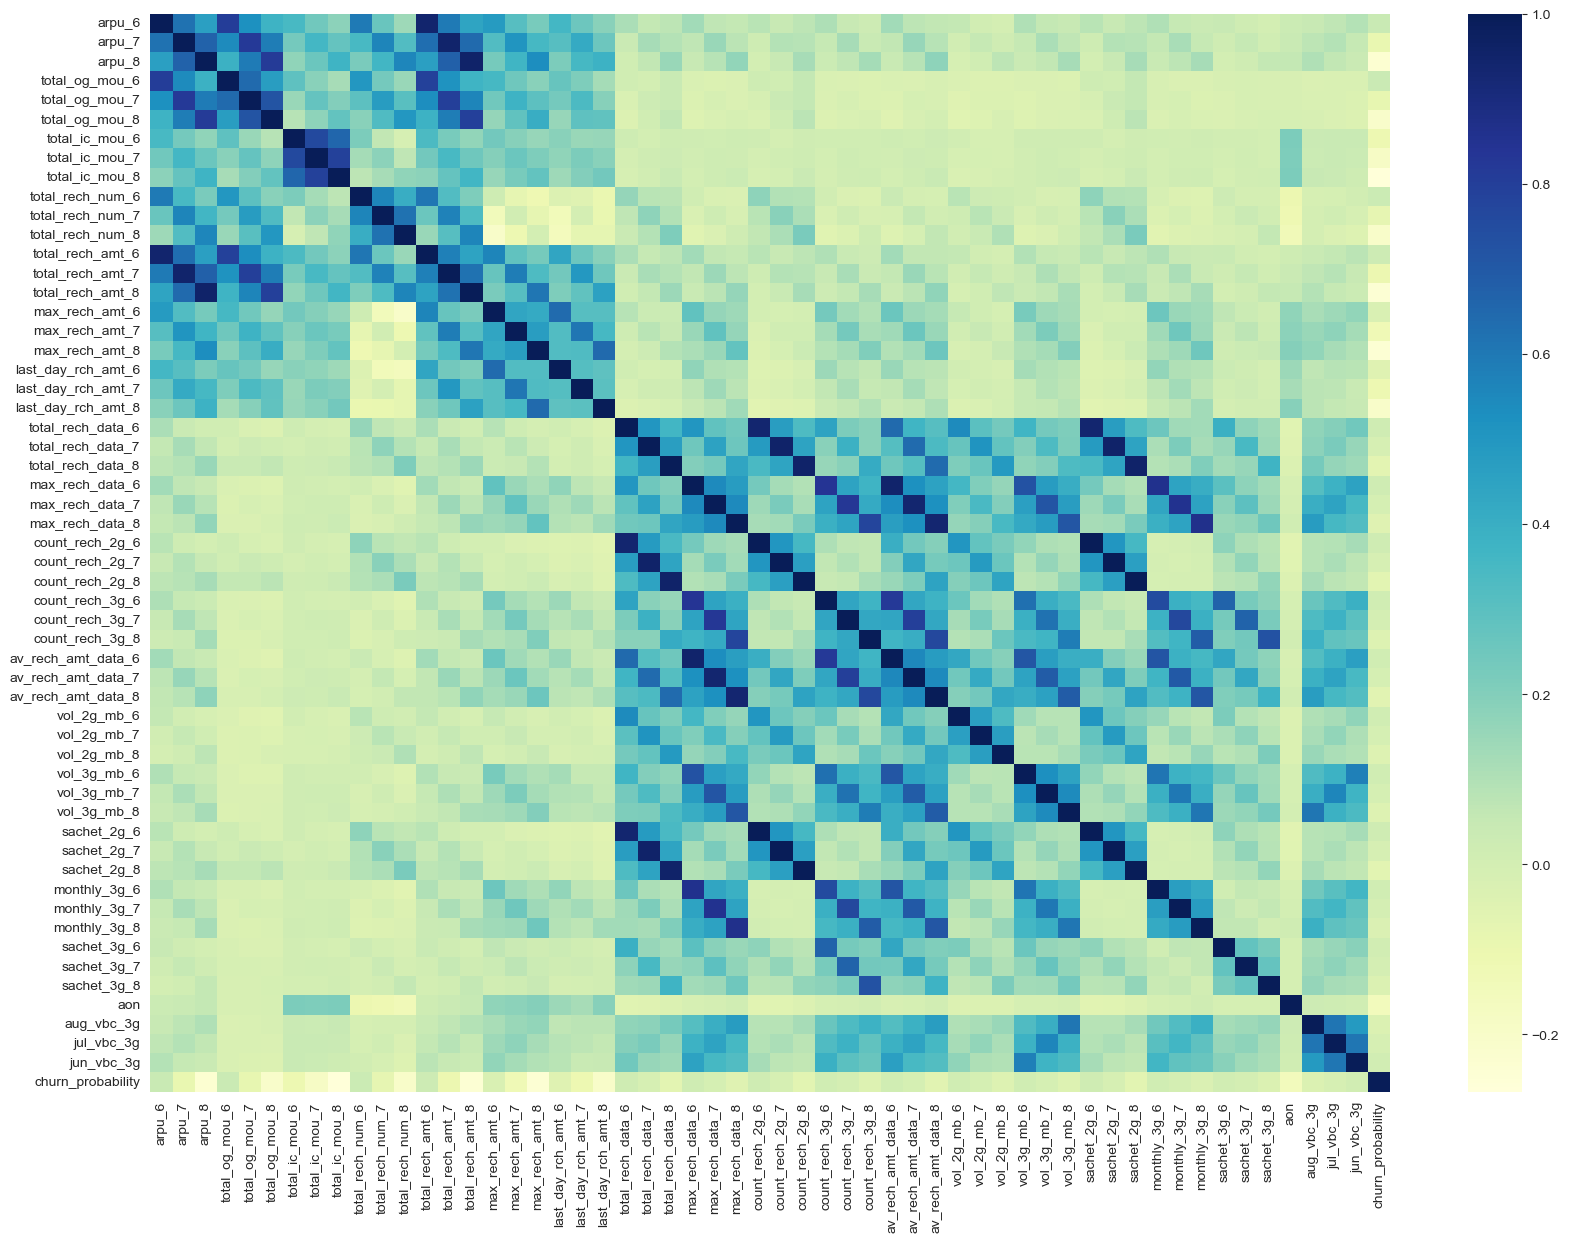

In [156]:
# Heatmap
plt.figure(figsize = (20,14))
sns.heatmap(train_db.corr(),cmap="YlGnBu", annot=False)
plt.show()

Observation:
The above heathmap shows there are strong correlations between the total incoming calls for 6,7,8 months, arpu6,arpu7, and vb_3g for months of June,July ,August

## Train-Test Split

In [157]:
# Separate Features and target variables
X=train_db.iloc[:,:-1]
y=train_db['churn_probability']

In [158]:
# Splitting data into train and test set 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)


## Data resampling for balancing data

In [160]:
# Instantiate SMOTE
sm = SMOTE(random_state=42)

In [161]:
# Fit SMOTE to the train set
X_train, y_train = sm.fit_resample(X_train, y_train)

In [162]:
X_train.head()

,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,...,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,155.170,-5.000,2.500,286.29,0.00,0.00,59.08,0.00,0.00,6,...,0,0,0,0,0,0,479,0.0,0.0,0.0
1,91.300,113.764,73.781,120.31,145.88,92.04,159.83,174.51,75.16,4,...,0,0,0,0,0,0,1068,0.0,0.0,0.0
2,591.520,241.930,58.500,357.96,210.23,0.00,1069.24,633.14,0.00,3,...,0,0,0,0,0,0,289,0.0,0.0,0.0
3,29.969,105.287,54.394,20.58,28.94,28.11,9.03,13.98,6.78,1,...,0,0,0,0,0,0,626,0.0,0.0,0.0
4,366.158,411.051,296.316,540.39,669.03,561.64,488.54,543.49,508.03,3,...,0,0,0,0,0,0,251,0.0,0.0,0.0


## Feature Scaling

In [163]:
# Instantiate the Scaler
scaler = StandardScaler()
# Fit the data into scaler and transform
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

In [164]:

# Transform val/Testset
X_test[X_train.columns] = scaler.transform(X_test[X_train.columns])

## Feature Selection/Importance

In [52]:
# Use Randomforest for feature selection
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [53]:
sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False])

In [54]:
# Check number of important features selected by randomforest
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

20

In [55]:

print(selected_feat)

Index(['arpu_6', 'arpu_7', 'arpu_8', 'total_og_mou_6', 'total_og_mou_7',
       'total_og_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8',
       'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7',
       'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'last_day_rch_amt_6', 'last_day_rch_amt_7',
       'last_day_rch_amt_8', 'aon'],
      dtype='object')


In [56]:
# Display Important features
selected_feat

Index(['arpu_6', 'arpu_7', 'arpu_8', 'total_og_mou_6', 'total_og_mou_7',
       'total_og_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8',
       'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7',
       'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'last_day_rch_amt_6', 'last_day_rch_amt_7',
       'last_day_rch_amt_8', 'aon'],
      dtype='object')

In [57]:
sel.get_support(indices=True)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 51], dtype=int64)

In [58]:
df_feature_imp=pd.DataFrame()
df_feature_imp['Feature']=selected_feat
df_feature_imp['Score']=[sel.estimator_.feature_importances_.ravel()[i] for i in sel.get_support(indices=True)]

Text(0.5, 1.0, 'Feature Importance')

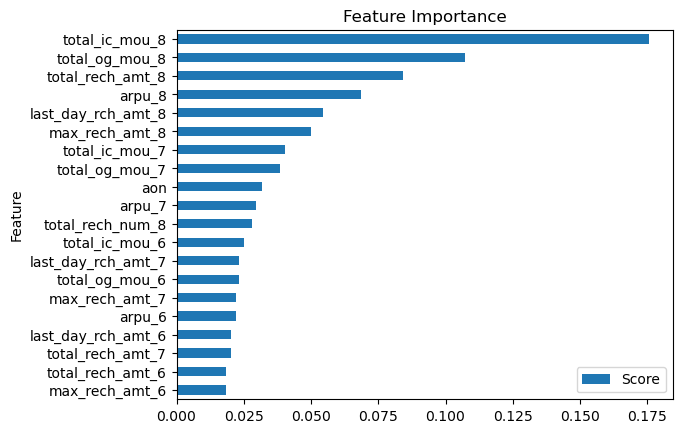

In [59]:
df_feature_imp.sort_values(by='Score').plot.barh(x='Feature',y='Score')
plt.title('Feature Importance')

## Logistic Regression without PCA using Feature selection

In [60]:
# Will create a function and call it again and again for different models
def model_evaluation(actual, pred):
    # Accuracy Score
    acc_score = round(accuracy_score(actual, pred)*100,2)
    
    # Precision score
    prec_score = round(precision_score(actual, pred)*100,2)
    
    # Recall score
    rec_score = round(recall_score(actual, pred)*100,2)
    
    # Confusion matrix
    confusion = confusion_matrix(actual, pred)
   
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    # Specificity
    Specificity= round(TN / float(TN+FP),2)
    # ROC AUC score
    roc_score = round(roc_auc_score(actual, pred)*100,2)
    #F1-Score
    f1_score=round(2*((prec_score*rec_score)/(prec_score+rec_score)),2)
    return {"TP":TP,"TN":TN,"FP":FP,"FN":FN,"Recall":rec_score,"Precision":prec_score,"Specificity":Specificity,"ROC/AUC Score":roc_score,"F1-Score":f1_score,}

In [61]:
# Build Logistic Regression using important features
X_New_train= X_train[selected_feat]
# Initialize the Logistic regression
model1 = LogisticRegression(random_state=42)
# fit the training data
model1.fit(X_New_train, y_train)
# predict the training data
Y_train_pred = model1.predict(X_New_train)
# predict the testing data
Y_test_pred = model1.predict(X_test[selected_feat])
# Model evaluation
train_eval=pd.DataFrame([model_evaluation(y_train, Y_train_pred)])
test_eval=pd.DataFrame([model_evaluation(y_test, Y_test_pred)])
df_eval=pd.concat([train_eval,test_eval])
df_eval['data']=['train_data','test_data']
df_eval.set_index('data',inplace=True)

Model Summary

In [62]:

df_eval

,TP,TN,FP,FN,Recall,Precision,Specificity,ROC/AUC Score,F1-Score
data,,,,,,,,,
train_data,29024,27161,6945,5082,85.1,80.69,0.80,82.37,82.84
test_data,902,6759,1744,190,82.6,34.09,0.79,81.05,48.26


## PCA

In [63]:
# initialize the pca with randomized
pca = PCA( random_state=42)
# fit the training dataset
pca.fit(X_train)

PCA(random_state=42)

In [64]:
# Fit train set on PCA
pca.fit(X_train)

PCA(random_state=42)

In [65]:
# Principal components
pca.components_

array([[ 7.78380762e-02,  1.23899400e-01,  1.23752134e-01, ...,
         1.48677627e-01,  1.51540025e-01,  1.33606340e-01],
       [ 1.91434146e-01,  2.75006138e-01,  2.58555757e-01, ...,
        -5.27733881e-02, -6.15397343e-02, -7.31098725e-02],
       [-7.52276979e-03, -4.40474244e-03, -1.82043012e-02, ...,
        -8.68405881e-02, -9.15369627e-02, -9.08310059e-02],
       ...,
       [ 0.00000000e+00, -3.75684717e-16,  2.84460565e-15, ...,
        -1.00880259e-15, -2.25315716e-16,  1.89934977e-16],
       [ 0.00000000e+00, -8.55412748e-17, -2.28511631e-16, ...,
        -6.48709074e-17, -1.81017676e-17, -9.47527543e-17],
       [ 0.00000000e+00, -3.87717432e-16, -7.74786046e-16, ...,
         1.23336753e-16, -5.07721785e-17,  1.61009780e-16]])

In [66]:
# Cumuliative varinace of the PCs
variance_cumu = np.cumsum(pca.explained_variance_ratio_)
variance_cumu

array([0.1983294 , 0.33372847, 0.42603075, 0.4956353 , 0.54385105,
       0.59050543, 0.63037885, 0.66285249, 0.69356901, 0.72128889,
       0.74554291, 0.76954921, 0.79246336, 0.8130405 , 0.82903598,
       0.84380889, 0.8578383 , 0.87082523, 0.88203262, 0.89258546,
       0.90275919, 0.91207561, 0.92041784, 0.92826318, 0.93523996,
       0.94169824, 0.94723211, 0.9524573 , 0.9575123 , 0.96230417,
       0.96690901, 0.97112135, 0.97518021, 0.97875893, 0.98172279,
       0.98425761, 0.98668092, 0.98876953, 0.99068581, 0.99251154,
       0.99373364, 0.99487168, 0.99572604, 0.99651358, 0.99726385,
       0.99787647, 0.99835094, 0.99881883, 0.99921845, 0.99950216,
       0.99976394, 1.        , 1.        , 1.        , 1.        ])

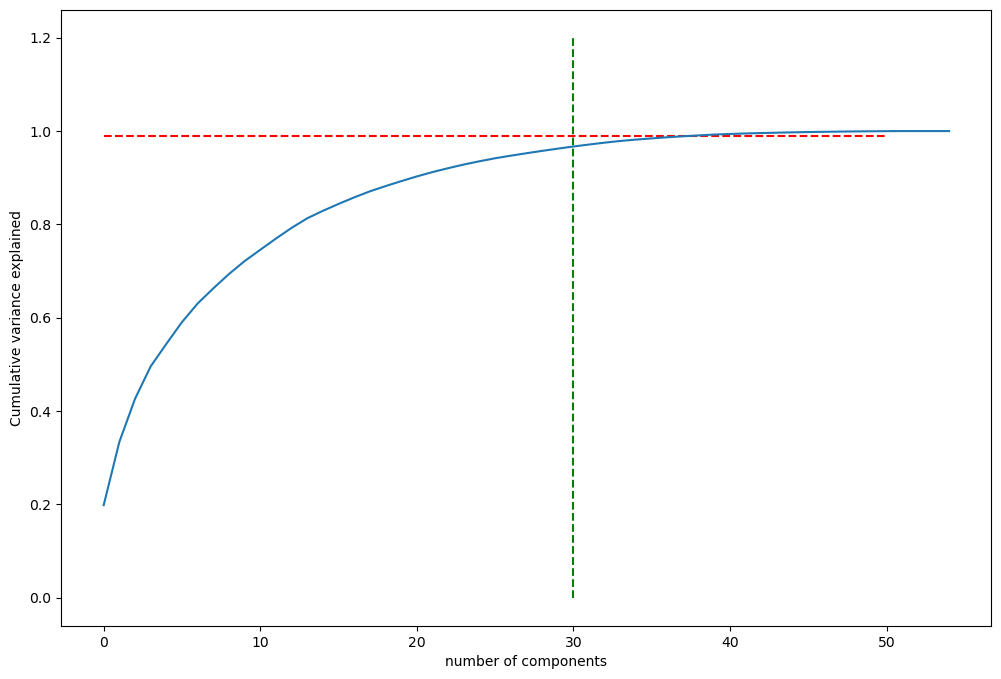

In [67]:
#Screeplot for the PCA components
fig = plt.figure(figsize=[12,8])
plt.vlines(x=30, ymax=1.2, ymin=0, colors="g", linestyles="--")
plt.hlines(y=0.99, xmax=50, xmin=0, colors="r", linestyles="--")
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('Cumulative variance explained')
plt.show()

In [68]:
# Instantiate PCA with 30 components
pca_final = IncrementalPCA(n_components=30)

In [69]:
# Fit and transform the X_train
X_train_pca = pca_final.fit_transform(X_train)

In [70]:
X_train_pca.shape

(68212, 30)

In [71]:
# Transofrm test data wtih pca
X_test_pca = pca_final.transform(X_test)

## Logistic regression with PCA

In [72]:
# Creating KFold object with 10 splits
folds = KFold(n_splits=10, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train_pca, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='recall', verbose=1)

In [73]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.355139,0.017146,0.009645,0.005944,0.01,{'C': 0.01},0.844793,0.843851,0.852498,0.850859,...,0.848355,0.848865,0.848513,0.848222,0.848569,0.847842,0.847900,0.847704,0.848459,0.000549
1,0.309466,0.049121,0.007495,0.003484,0.1,{'C': 0.1},0.844502,0.844438,0.854567,0.852365,...,0.849071,0.849514,0.849393,0.849167,0.849514,0.848888,0.849073,0.848877,0.849391,0.000467
2,0.287910,0.030707,0.005457,0.004228,1,{'C': 1},0.844502,0.845025,0.854271,0.852365,...,0.849006,0.849579,0.849490,0.849200,0.849514,0.848953,0.849041,0.848844,0.849424,0.000517
3,0.358287,0.024269,0.009659,0.005938,10,{'C': 10},0.844502,0.845025,0.854271,0.852365,...,0.849006,0.849579,0.849556,0.849167,0.849547,0.848920,0.849041,0.848909,0.849433,0.000516
4,0.343313,0.027164,0.007255,0.006556,100,{'C': 100},0.844502,0.845025,0.854271,0.852365,...,0.849006,0.849579,0.849556,0.849167,0.849547,0.848920,0.849041,0.848909,0.849433,0.000516
5,0.295572,0.027150,0.008761,0.005134,1000,{'C': 1000},0.844502,0.845025,0.854271,0.852365,...,0.849006,0.849579,0.849556,0.849167,0.849547,0.848920,0.849041,0.848909,0.849437,0.000524


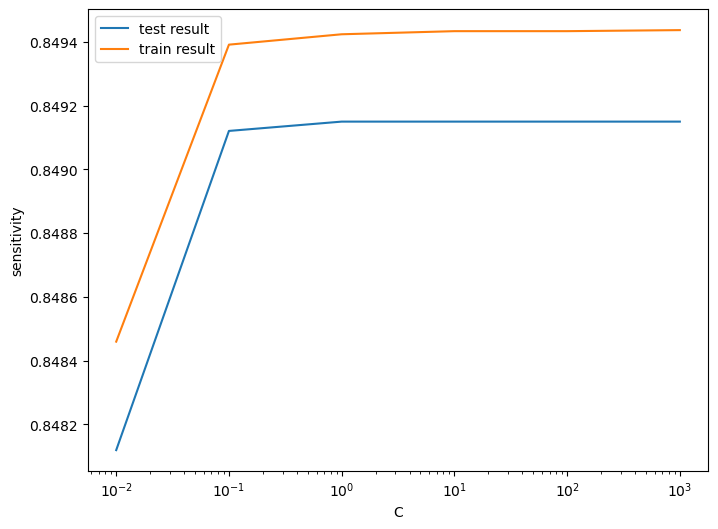

In [74]:
# plot of C versus train and validation scores

plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('sensitivity')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [75]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test sensitivity is {0} at C = {1}".format(best_score, best_C))

 The highest test sensitivity is 0.8491495850778786 at C = 1


In [76]:
# Instantiate the model with best C
logistic_pca = LogisticRegression(class_weight='balanced',C=best_C)

# Fit the model on the train set
log_pca_model = logistic_pca.fit(X_train_pca, y_train)

# predict the training data
Y_train_pred = log_pca_model.predict(X_train_pca)
# predict the testing data
Y_test_pred = log_pca_model.predict(X_test_pca)
# Model evaluation
train_eval=pd.DataFrame([model_evaluation(y_train, Y_train_pred)])
test_eval=pd.DataFrame([model_evaluation(y_test, Y_test_pred)])
df_eval=pd.concat([train_eval,test_eval])
df_eval['data']=['train_data','test_data']
df_eval.set_index('data',inplace=True)

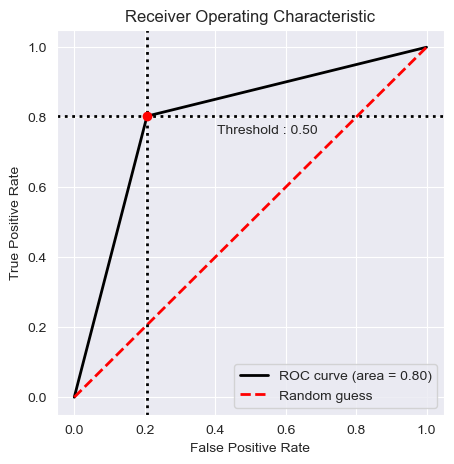

In [77]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, Y_test_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [78]:
#conda install -c conda-forge scikit-plot

In [79]:
#pip install plot-metric

In [80]:

df_eval

,TP,TN,FP,FN,Recall,Precision,Specificity,ROC/AUC Score,F1-Score
data,,,,,,,,,
train_data,28969,27227,6879,5137,84.94,80.81,0.80,82.38,82.82
test_data,877,6747,1756,215,80.31,33.31,0.79,79.83,47.09


## Decision Tree Model

In [81]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(10,20,10),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dtree = DecisionTreeClassifier(class_weight='balanced',random_state=42)

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'recall',
                           cv = 5, 
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_pca,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': range(10, 20, 10),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='recall', verbose=1)

In [82]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.247706,0.534003,0.015360,0.002332,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.778657,0.834482,0.827738,0.833162,0.836974,0.822203,0.021981,1
1,3.500600,0.471714,0.010394,0.005356,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.778657,0.834482,0.827738,0.833162,0.836974,0.822203,0.021981,1
2,3.876718,1.026092,0.015673,0.003720,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.770742,0.835655,0.825685,0.820408,0.819381,0.814374,0.022566,3
3,3.597269,0.256085,0.013824,0.001832,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.770742,0.835655,0.825685,0.820408,0.819381,0.814374,0.022566,3


In [83]:
# Printing the optimal sensitivity score and hyperparameters
print("Best score:-", grid_search.best_score_)
print(grid_search.best_estimator_)

Best score:- 0.8222026489580632
DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=50, min_samples_split=50,
                       random_state=42)


In [84]:
# Instantiate the model with best C
dt_pca = DecisionTreeClassifier(class_weight='balanced', criterion = "gini",max_depth=10,
                       min_samples_leaf=50, min_samples_split=50,
                       random_state=42)

# Fit the model on the train set
dt_pca_model = dt_pca.fit(X_train_pca, y_train)

# predict the training data
Y_train_pred = dt_pca_model.predict(X_train_pca)
# predict the testing data
Y_test_pred = dt_pca_model.predict(X_test_pca)
# Model evaluation
train_eval=pd.DataFrame([model_evaluation(y_train, Y_train_pred)])
test_eval=pd.DataFrame([model_evaluation(y_test, Y_test_pred)])
df_eval=pd.concat([train_eval,test_eval])
df_eval['data']=['train_data','test_data']
df_eval.set_index('data',inplace=True)

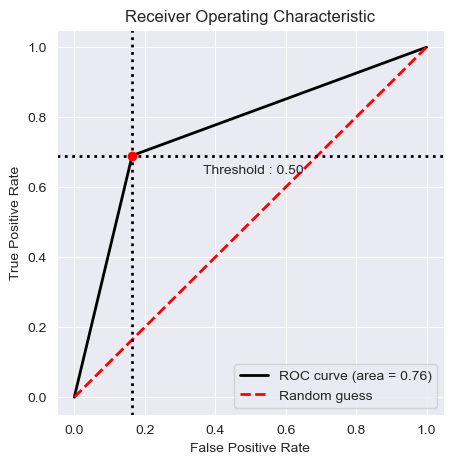

In [85]:
# Visualisation with plot_metric
bc = BinaryClassification(y_test, Y_test_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [86]:
df_eval

,TP,TN,FP,FN,Recall,Precision,Specificity,ROC/AUC Score,F1-Score
data,,,,,,,,,
train_data,28798,29212,4894,5308,84.44,85.47,0.86,85.04,84.95
test_data,754,7105,1398,338,69.05,35.04,0.84,76.30,46.49


## RandomForest Model

In [87]:
from sklearn.ensemble import RandomForestClassifier

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [89]:
param_grid = {
    'max_depth': range(10,20,10),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'max_features': [20],
    'n_estimators':[300]
}
# Create a based model
rf = RandomForestClassifier(class_weight='balanced')
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           cv = 3,
                           verbose = 1, 
                           scoring='recall',
                           return_train_score=True)

# Fit the model
grid_search.fit(X_train_pca, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': range(10, 20, 10), 'max_features': [20],
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50),
                         'n_estimators': [300]},
             return_train_score=True, scoring='recall', verbose=1)

In [91]:
print("Best Score",grid_search.best_score_)
print("Best Params",grid_search.best_params_)

Best Score 0.8340765469277905
Best Params {'max_depth': 10, 'max_features': 20, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 300}


In [92]:
# Instantiate the model with best C
rfc_pca = RandomForestClassifier(class_weight='balanced',
                             max_depth=10,
                             min_samples_leaf=50, 
                             min_samples_split=50,
                             max_features=20,
                             n_estimators=300,
                       random_state=42)

# Fit the model on the train set
rfc_pca_model = rfc_pca.fit(X_train_pca, y_train)

# predict the training data
Y_train_pred = rfc_pca_model.predict(X_train_pca)
# predict the testing data
Y_test_pred = rfc_pca_model.predict(X_test_pca)
# Model evaluation
train_eval=pd.DataFrame([model_evaluation(y_train, Y_train_pred)])
test_eval=pd.DataFrame([model_evaluation(y_test, Y_test_pred)])
df_eval=pd.concat([train_eval,test_eval])
df_eval['data']=['train_data','test_data']
df_eval.set_index('data',inplace=True)

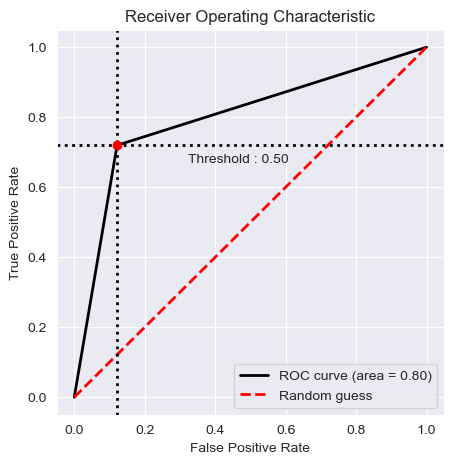

In [93]:
# Visualisation with plot_metric
bc = BinaryClassification(y_test, Y_test_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [94]:
df_eval

,TP,TN,FP,FN,Recall,Precision,Specificity,ROC/AUC Score,F1-Score
data,,,,,,,,,
train_data,29196,30265,3841,4910,85.60,88.37,0.89,87.17,86.96
test_data,786,7470,1033,306,71.98,43.21,0.88,79.91,54.00


## XGBOOST Model

In [97]:
pip install hyperopt


     ---------------------------------------- 1.6/1.6 MB 14.4 MB/s eta 0:00:00
     ------------------------------------- 200.5/200.5 kB 11.9 MB/s eta 0:00:00


In [98]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [99]:
space={'max_depth': hp.quniform("max_depth", 3, 20, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 500,
        'seed': 42,

    }

In [100]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train_pca, y_train), ( X_test_pca, y_test)]
    
    clf.fit(X_train_pca, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test_pca)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [101]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.7603960396039604                                     
SCORE:                                                                            
0.7622720166753517                                                                
SCORE:                                                                            
0.7574778530484627                                                                
SCORE:                                                                            
0.7632100052110474                                                                
SCORE:                                                                            
0.7587285044293903                                                                
SCORE:                                                                            
0.7606044815007816                                                                
SCORE:                                                    

SCORE:                                                                             
0.7635226680562793                                                                 
SCORE:                                                                             
0.7597707139134966                                                                 
SCORE:                                                                             
0.7560187597707139                                                                 
SCORE:                                                                             
0.7601875977071392                                                                 
SCORE:                                                                             
0.7641479937467431                                                                 
SCORE:                                                                             
0.7642522146951537                                                          

0.7568525273579989                                                                 
SCORE:                                                                             
0.7605002605523711                                                                 
SCORE:                                                                             
0.7638353309015112                                                                 
100%|██████████| 100/100 [04:48<00:00,  2.89s/trial, best loss: -0.7666492965085983]


In [102]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.879221078351669, 'gamma': 7.40617868937308, 'max_depth': 4.0, 'min_child_weight': 5.0, 'reg_alpha': 43.0, 'reg_lambda': 0.4353490291967609}


In [103]:
# Instantiate the model with best C
xgb_pca = XGBClassifier(objective = 'binary:logistic',
                         colsample_bytree=0.702068970235341,
                            max_depth= 10,
                            min_child_weight= 8.0,
                            reg_alpha=105.0,
                            seed= 42,
                            gamma=7.538408376768269,
                            reg_lambda=0.8946625863735224,
                           
                        )

# Fit the model on the train set
xgb_pca_model = xgb_pca.fit(X_train_pca, y_train)

# predict the training data
Y_train_pred = xgb_pca_model.predict(X_train_pca)
# predict the testing data
Y_test_pred = xgb_pca_model.predict(X_test_pca)
# Model evaluation
train_eval=pd.DataFrame([model_evaluation(y_train, Y_train_pred)])
test_eval=pd.DataFrame([model_evaluation(y_test, Y_test_pred)])
df_eval=pd.concat([train_eval,test_eval])
df_eval['data']=['train_data','test_data']
df_eval.set_index('data',inplace=True)

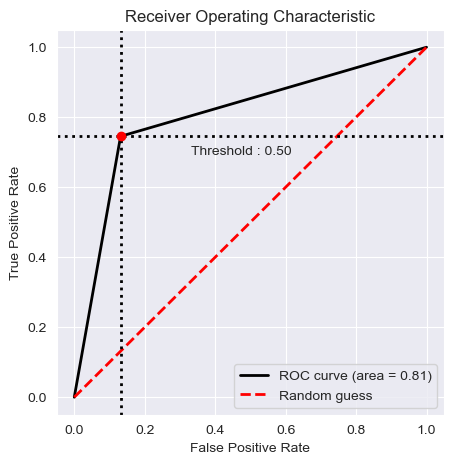

In [104]:
# Visualisation with plot_metric
bc = BinaryClassification(y_test, Y_test_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [105]:
df_eval

,TP,TN,FP,FN,Recall,Precision,Specificity,ROC/AUC Score,F1-Score
data,,,,,,,,,
train_data,29788,29864,4242,4318,87.34,87.53,0.88,87.45,87.43
test_data,814,7385,1118,278,74.54,42.13,0.87,80.70,53.83


Observation:
Of all the models XGBoost with PCA has better accuracy on unseen data compared to other models with unseen data accuracy around 0.89

## Model prediction on Unseen Data

In [108]:
# Load the unseen data
unseen_data=pd.read_csv('test.csv')
unseen_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


In [166]:
# Identify the Recharge columns
recharge_cols = [k for k in train_db.columns.to_list() if 'rech' in k]
# Impute Recharge columns with 0
for col in recharge_cols:
    unseen_data[col]=unseen_data[col].fillna(0)

In [110]:
# Select the columns used in train data
unseen_df=unseen_data[X_train.columns]
unseen_df[unseen_df.columns]=scaler.transform(unseen_df[unseen_df.columns])

In [111]:
# Transofrm test data wtih pca
unseen_data_pca = pca_final.transform(unseen_df)

In [112]:
# predict the unseen data
#Y_unseen_pred = logistic_pca.predict(unseen_data_pca)

In [113]:

preds=xgb_pca_model.predict(unseen_data_pca)

## Save the Predictions

In [114]:
sample=pd.read_csv('sample (2).csv')

In [115]:
sample['churn_probability']=preds#Y_unseen_pred

In [116]:

sample.to_csv('Submission_final_xgb.csv',index=False)